In [19]:
import collections
import nltk
from nltk import agreement
import os
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import jieba
import csv
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
porn = open("porn.txt","r").read().split("\n")
profanity = open("profanity.txt","r").read().split("\n")
pronoun = open("pronoun.txt","r").read().split("\n")
positive_words = open("positive_words.txt","r").read().split("\n")
negative_words = open("negative_words.txt","r").read().split("\n")

In [3]:
df2= pd.read_excel("Anno-1000.xlsx")
ocr=df2.iloc[:,2]

In [4]:
s_ocr=[] #建立存储分词的列表
for i in range(len(ocr)):
    result=[]
    seg_list = jieba.cut(ocr[i])
    for w in seg_list :#读取每一行分词
        result.append(w)
    s_ocr.append(result)#将该行分词写入列表形式的总分词列表

Building prefix dict from /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jieba/dict.txt ...
Dumping model to file cache /var/folders/s3/x6bgjnss22ggm9fct3z9mgz00000gn/T/jieba.cache
Loading model cost 1.9184770584106445 seconds.
Prefix dict has been built succesfully.


In [5]:
df2['cln_content'] = s_ocr

## Porn Score

In [8]:
porn_score = []
for text in list(df2.cln_content):
    result=0
    for words in porn:
         if words in text:
                 result += 1 
    porn_score.append(result)
    porn_score
df2['porn_score']=porn_score

## Profanity Score

In [9]:
profanity_score = []
for text in list(df2.cln_content):
    result=0
    for words in profanity:
         if words in text:
                 result += 1 
    profanity_score.append(result)
    profanity_score
df2['profanity_score']=profanity_score

## Pronoun Count

In [10]:
pronoun_count = []
for text in list(df2.cln_content):
    result=0
    for words in pronoun:
         if words in text:
                 result += 1 
    pronoun_count.append(result)
    pronoun_count
df2['pronoun_count']=pronoun_count

## Sentiment Score

In [12]:
positive_score = []
for text in list(df2.cln_content):
    result = 0
    for words in positive_words:
        if words in text:
            result += 1
    positive_score.append(result)
# positive_score

In [13]:
negative_score = []
for text in list(df2.cln_content):
    result = 0
    for words in negative_words:
        if words in text:
            result -= 1
    negative_score.append(result)
# negative_score

In [14]:
df2['polarity_score'] = [positive_score[i] + negative_score[i] for i in range(len(positive_score))]

In [16]:
df2.loc[df2.polarity_score > 0, 'sentiment'] = '1' 
df2.loc[df2.polarity_score < 0, 'sentiment'] = '-1' 
df2.loc[df2.polarity_score == 0, 'sentiment'] = '0'

In [17]:
sentiment=df2['sentiment']

## Calculating Quadratic Weighted Kappa

In [20]:
dh1=df2['dh_1']
A = np.array(dh1)
dh2=df2['dh_2']
B = np.array(dh2)

In [21]:
confusion_matrix(A, B)

array([[518,  44,   6,   4],
       [ 69,  42,  20,  14],
       [ 38,  58,  87,  78],
       [  9,   4,   3,   8]])

In [22]:
w = np.zeros((4,4))

In [23]:
for i in range(len(w)):
    for j in range(len(w)):
        w[i][j] = float(((i-j)**2)/16) 

In [24]:
w

array([[0.    , 0.0625, 0.25  , 0.5625],
       [0.0625, 0.    , 0.0625, 0.25  ],
       [0.25  , 0.0625, 0.    , 0.0625],
       [0.5625, 0.25  , 0.0625, 0.    ]])

In [25]:
N=4
A_hist=np.zeros([N])
for item in A: 
    A_hist[item]+=1
    
B_hist=np.zeros([N])
for item in B: 
    B_hist[item]+=1

In [26]:
E = np.outer(A_hist, B_hist)

In [27]:
O = confusion_matrix(A, B)

In [28]:
E = E/E.sum(); E.sum()
O = O/O.sum(); O.sum()

1.0

In [29]:
num=0
den=0
for i in range(len(w)):
    for j in range(len(w)):
        num+=w[i][j]*O[i][j]
        den+=w[i][j]*E[i][j]
 
weighted_kappa = (1 - (num/den)); weighted_kappa

0.6703351531147185

Calculates the quadratic weighted kappa
axquadratic_weighted_kappa calculates the quadratic weighted kappa
value, which is a measure of inter-rater agreement between two raters
that provide discrete numeric ratings.  Potential values range from -1
(representing complete disagreement) to 1 (representing complete
agreement).  A kappa value of 0 is expected if all agreement is due to
chance. quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b each correspond to a list of integer ratings.  These lists must have the same length.
The ratings should be integers, and it is assumed that they contain the complete range of possible ratings.
quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating is the minimum possible rating, and max_rating is the maximum possible rating.
https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps

## Plotting

In [30]:
import matplotlib.pyplot as plt

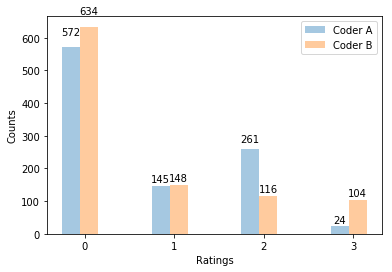

In [31]:
labels = ['0', '1', '2', '3']
col_count = 4
bar_width = 0.2
index = np.arange(col_count)
A_counts = [572, 145, 261, 24]
B_counts = [634,148, 116, 104]
A = plt.bar(index,
           A_counts, 
           bar_width,
           alpha=.4,
           label="Coder A") 
B = plt.bar(index+0.2,
            B_counts,
            bar_width,
            alpha=.4,
            label="Coder B")
def createLabels(data):
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
        )
createLabels(A)
createLabels(B)
plt.xlabel("Ratings")
plt.ylabel("Counts")
plt.xticks(index+.3 / 2 ,("0","1","2","3"))
plt.legend() #要使用label要加這行
#plt.title("The Distribution of Dark Humor Ratings Aggreement")
#plt.grid(True)
plt.show()



In [35]:
df2['avg_rat']=df2[['dh_1', 'dh_2']].mean(axis=1)
print(df2['avg_rat'].describe())

count    1002.000000
mean        0.714072
std         0.897511
min         0.000000
25%         0.000000
50%         0.000000
75%         1.500000
max         3.000000
Name: avg_rat, dtype: float64


In [36]:
df2.head(5)

,ID,Images,OCR,Template_Name,dh_1,dh_2,cln_content,porn_score,profanity_score,pronoun_count,polarity_score,sentiment,avg_rat
0,1,NaN,當我再差幾秒就遲到時，卻在這幾秒內衝到學校。我。學校。,自信的善逸,0,0,"[當我, 再, 差, 幾秒, 就, 遲到, 時, ，, 卻, 在, 這幾秒, 內, 衝到, ...",0,0,1,0,0,0.0
1,2,NaN,當你以為他們要幫你拿倉鼠飼料來餵你吃，但手上卻是拿著兩條蟒蛇加上一個攝影機。,怕爆倉鼠,0,2,"[當你以, 為, 他們, 要, 幫, 你, 拿, 倉鼠, 飼料, 來, 餵, 你, 吃, ，...",0,0,1,0,0,1.0
2,3,NaN,紅燈了行人大搖大擺的過馬路。行人。台灣的計程車司機\n,小丑被車撞,0,1,"[紅燈, 了, 行, 人大, 搖大, 擺, 的, 過馬路, 。, 行人, 。, 台灣, 的,...",0,0,0,0,0,0.5
3,4,NaN,辛普森家庭從來不會讓我失望。AREA 51 WARNING:DO NOT ENTER!\n\n,51禁區辛普森家族早就知道了,0,0,"[辛普森, 家庭, 從來, 不會, 讓, 我, 失望, 。, AREA, , 51, ,...",0,0,1,-3,-1,0.0
4,5,NaN,武漢肺炎疫情日漸嚴重。習近平:,小熊維尼笑,0,1,"[武漢, 肺炎, 疫情, 日漸, 嚴重, 。, 習近, 平, :]",0,0,0,-2,-1,0.5


In [38]:
pickle.dump(df2, open('df2.pkl', 'wb'))
#df = pickle.load(open('df_p2v2.pkl', 'rb')) 